# BUDHA


In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Datos del budha

In [34]:
checkerboard = (10, 7) # (points_per_row, points_per_colum)
square_size_mm = 24.2 # square side size in millimeters


In [35]:
from calib import board_points

# creamos los puntos del mundo del objeto checkerboard
checkerboard_world_points_mm = board_points(checkerboard) * square_size_mm

In [36]:
import glob, os

directory = os.path.join("datasets","stereo_budha_board", "calib")
left_files_pattern = "*left*.jpg"
right_files_pattern = "*right*.jpg"

def numeric_sort(file_name):
    return int(file_name.split("_")[-1].split(".")[0])

left_file_names = sorted(
    glob.glob(
        os.path.join(directory, left_files_pattern)
    ),
    key=numeric_sort
)

right_file_names = sorted(
    glob.glob(
        os.path.join(directory, right_files_pattern)
    ),
    key=numeric_sort
)

num_left = len(left_file_names)
num_right = len(right_file_names)





# --- AÑADE ESTAS LÍNEAS PARA DEPURAR ---
print(f"Directorio de búsqueda: {directory}")
print(f"Ruta absoluta: {os.path.abspath(directory)}")
print(f"Archivos izquierdos encontrados: {num_left}")
print(f"Archivos derechos encontrados: {num_right}")

if num_left > 0:
    print(f"Ejemplo de archivo izquierdo: {left_file_names[0]}")
# --- FIN DE LÍNEAS DE DEPURACIÓN ---

if  num_left != num_right:
    raise Exception(f"the number of files (left {num_left} / right{num_right}) doesn't match")




Directorio de búsqueda: datasets\stereo_budha_board\calib
Ruta absoluta: c:\vision_artificial\tp2_git\tp2_reconstruccion_3d\datasets\stereo_budha_board\calib
Archivos izquierdos encontrados: 28
Archivos derechos encontrados: 28
Ejemplo de archivo izquierdo: datasets\stereo_budha_board\calib\calib_left_0.jpg


In [37]:
import cv2

image_size = None
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)

world_points = []
left_images = []
right_images = []
left_images_points = []
right_images_points = []

for left_file_name, right_file_name in zip(
    left_file_names, right_file_names
):

    print("processing", left_file_name, right_file_name)

    # read left and right images
    left_image = cv2.imread(left_file_name, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_file_name, cv2.IMREAD_GRAYSCALE)

    # get the images sizes
    left_size = (left_image.shape[1], left_image.shape[0])
    right_size = (right_image.shape[1], right_image.shape[0])

    # checks that images sizes match
    if left_size != right_size:
        raise Exception(f"left and right images sizes differ: left {left_size} / right {right_size}")
        
    if image_size is None:
        # remembers the images size
        image_size = left_size
    else:
        if image_size != left_size:
            raise Exception(f"there are images with different sizes: {image_size} vs {left_size}")

    # finds the checkerboard in each image
    left_found, left_corners = cv2.findChessboardCorners(left_image, checkerboard)
    right_found, right_corners = cv2.findChessboardCorners(right_image, checkerboard)

    if not left_found or not right_found:
        print("warning, checkerboard was not found")
        continue

    # checkerboard was found in both images.

    # let's improve the found corners
    corners_left = cv2.cornerSubPix(left_image, left_corners, (7, 7), (-1,-1), criteria)
    corners_right = cv2.cornerSubPix(right_image, right_corners, (7, 7), (-1,-1), criteria)

    # acumulo las imagenes
    left_images.append(left_image)
    right_images.append(right_image)

    # acumulo los corners detectados
    left_images_points.append(left_corners)
    right_images_points.append(right_corners)

    # acumulo los puntos del mundo
    world_points.append(checkerboard_world_points_mm)

print(f"Imágenes izquierdas: {len(left_images)}")
print(f"Imágenes derechas: {len(right_images)}")

processing datasets\stereo_budha_board\calib\calib_left_0.jpg datasets\stereo_budha_board\calib\calib_right_0.jpg
processing datasets\stereo_budha_board\calib\calib_left_1.jpg datasets\stereo_budha_board\calib\calib_right_1.jpg
processing datasets\stereo_budha_board\calib\calib_left_2.jpg datasets\stereo_budha_board\calib\calib_right_2.jpg
processing datasets\stereo_budha_board\calib\calib_left_3.jpg datasets\stereo_budha_board\calib\calib_right_3.jpg
processing datasets\stereo_budha_board\calib\calib_left_4.jpg datasets\stereo_budha_board\calib\calib_right_4.jpg
processing datasets\stereo_budha_board\calib\calib_left_5.jpg datasets\stereo_budha_board\calib\calib_right_5.jpg
processing datasets\stereo_budha_board\calib\calib_left_6.jpg datasets\stereo_budha_board\calib\calib_right_6.jpg
processing datasets\stereo_budha_board\calib\calib_left_7.jpg datasets\stereo_budha_board\calib\calib_right_7.jpg
processing datasets\stereo_budha_board\calib\calib_left_8.jpg datasets\stereo_budha_boar

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None, ax=None, figsize=(5, 5)):
    """
    Muestra una imagen (convirtiendo de BGR a RGB si es necesario).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Asumir que es BGR si tiene 3 canales, convertir a RGB
    # (OpenCV lee en BGR, Matplotlib muestra en RGB)
    if img.ndim == 3 and img.shape[2] == 3:
        img_rgb = img[..., ::-1]  # Convertir BGR a RGB
        ax.imshow(img_rgb)
    # Si es 2D (escala de grises)
    elif img.ndim == 2:
        ax.imshow(img, cmap='gray')
    # Si ya está en RGB o es otro formato
    else:
        ax.imshow(img)
        
    ax.axis('off')
    if title:
        ax.set_title(title)
    
    return ax

def show_images(images, titles=None, figsize_per_img=(5, 5)):
    """
    Muestra una lista de imágenes una al lado de la otra.
    
    images: lista de imágenes [img1, img2, ...]
    titles: lista de títulos [title1, title2, ...]
    """
    n = len(images)
    if n == 0:
        print("No hay imágenes para mostrar.")
        return

    if titles is None:
        titles = [''] * n
    
    if len(images) != len(titles):
        raise ValueError("La lista de imágenes y de títulos debe tener el mismo tamaño.")

    # Calcular el tamaño total de la figura
    figsize = (figsize_per_img[0] * n, figsize_per_img[1])
    
    fig, axes = plt.subplots(1, n, figsize=figsize)
    
    # Asegurarse de que 'axes' sea siempre una lista para poder iterar
    if n == 1:
        axes = [axes]
        
    for ax, img, title in zip(axes, images, titles):
        # Usar la función helper 'imshow'
        imshow(img, title, ax=ax)
    
    plt.tight_layout()
    plt.show()


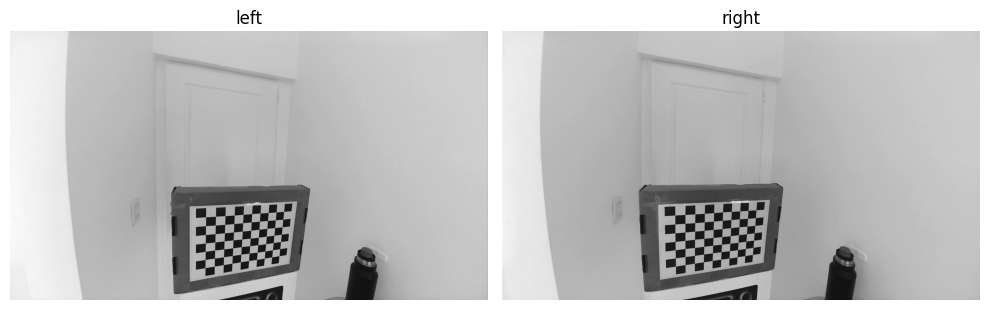

In [39]:
show_images([
    left_images[14], right_images[14]
], ['left', 'right'])

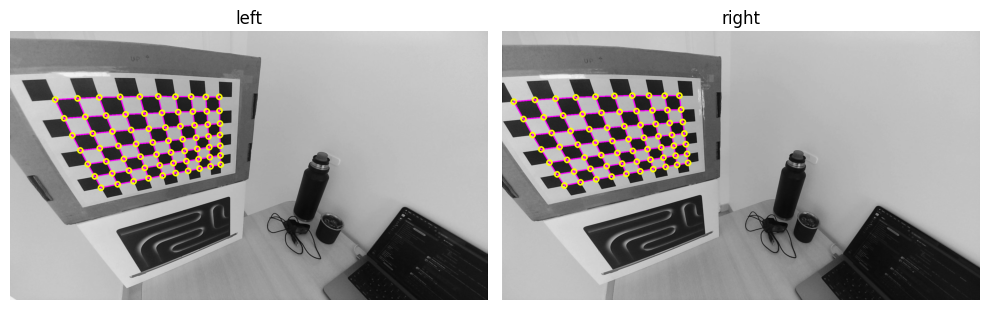

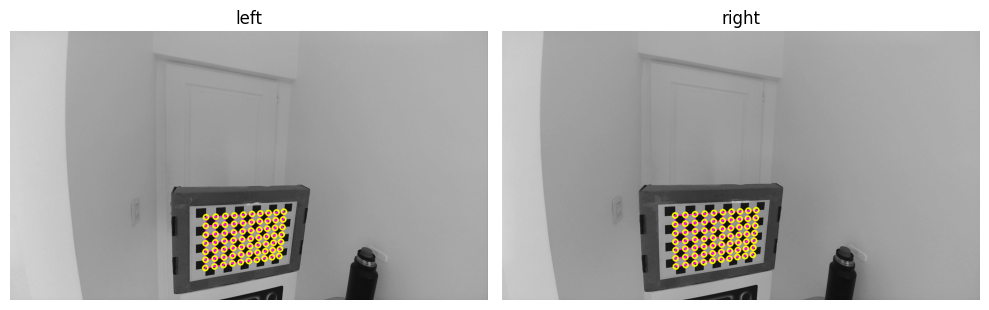

In [40]:
# grafiquemos algunos checkerboards
# y sus detecciones de corners
#  para verificar que lo que encontró está ok:

import calib
some_images_indices = [5, 14]

draw_settings = {
    "corner_radius": 10,
    "corner_thickness": 5,
    "line_thickness": 4
}
for i in some_images_indices:

    left_img, right_img = left_images[i], right_images[i]
    left_corners, right_corners = left_images_points[i], right_images_points[i]

    show_left = cv2.cvtColor(left_img, cv2.COLOR_GRAY2BGR)
    show_right = cv2.cvtColor(right_img, cv2.COLOR_GRAY2BGR)


    calib.draw_checkerboard(show_left, checkerboard, left_corners, True, **draw_settings)
    calib.draw_checkerboard(show_right, checkerboard, right_corners, True, **draw_settings)
    

    show_images([show_left, show_right], ["left", "right"])
    


In [41]:
# Calibramos Stereo

print("Calibrating Stereo")
print("num images:", len(left_images_points))

err, left_K, left_dist, right_K, right_dist, R, T, E, F = cv2.stereoCalibrate(
    world_points, 
    left_images_points, 
    right_images_points, 
    None, 
    None, 
    None, 
    None, 
    image_size, 
    flags=0
)

Calibrating Stereo
num images: 28


In [42]:
from calib import np_print

to_print = [

    "# Left camera Intrinsics:",
    ("left_K", left_K),
    ("left_dist", left_dist),

    "# Right camera Intrinsics:",
    ("right_K", right_K),
    ("right_dist", right_dist),

    "# Rotation:",
    ("R", R),

    "# Translation:",
    ("T", T),
    
    "# Essential Matrix:",
    ("E", E),
    
    "# Fundamental Matrix:",
    ("F", F),
        
]

In [43]:
print("# STEREO CALIBRATION")
for line in to_print:

    if isinstance(line, str):   
        print(line)
    else:
        var_name, np_array = line
        print(f"{var_name} = {np_print(np_array)}\n")

# STEREO CALIBRATION
# Left camera Intrinsics:
left_K = np.array([
	[   600.569,	     0.000,	   963.433],
	[     0.000,	   600.775,	   548.961],
	[     0.000,	     0.000,	     1.000]
])

left_dist = np.array([
	[  0.004782,	 -0.023202,	 -0.000496,	  0.001601,	  0.003510]
])

# Right camera Intrinsics:
right_K = np.array([
	[   600.059,	     0.000,	   960.028],
	[     0.000,	   599.822,	   535.499],
	[     0.000,	     0.000,	     1.000]
])

right_dist = np.array([
	[  0.001949,	 -0.021507,	 -0.000628,	  0.000322,	  0.003217]
])

# Rotation:
R = np.array([
	[     1.000,	    -0.000,	     0.010],
	[     0.000,	     1.000,	     0.010],
	[    -0.010,	    -0.010,	     1.000]
])

# Translation:
T = np.array([
	[-59.300782],
	[  0.584879],
	[ -0.325488]
])

# Essential Matrix:
E = np.array([
	[    -0.006,	     0.320,	     0.588],
	[    -0.917,	    -0.571,	    59.292],
	[    -0.589,	   -59.298,	    -0.577]
])

# Fundamental Matrix:
F = np.array([
	[     0.000,	    -0.000,	    -0.001],
	[     0.0

In [44]:
# serializamos los resultados en un pickle
import pickle

calibration_results = {
    'left_K': left_K,
    'left_dist': left_dist,
    'right_K': right_K,
    'right_dist': right_dist,
    'R': R,
    'T': T,
    'E': E,
    'F': F,
    'image_size': image_size,
}

calibration_file = os.path.join("datasets","stereo_budha_board" ,"stereo_calibration.pkl")
with open(calibration_file, "wb") as f:
    f.write(pickle.dumps(calibration_results))
        


In [45]:
# para recuperar los resultados podemos cargarlos usando pickle:

with open(calibration_file, "rb") as f:
    results2 = pickle.loads(f.read())


results2.keys()

dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])

In [46]:
# realicemos la rectificación estéreo:

R1, R2, P1_matriz, P2_matriz, Q, validRoi1, validRoi2 = cv2.stereoRectify(
    left_K, left_dist, right_K, right_dist, image_size, R, T, alpha=0
)


## Mapas

In [47]:
# calculemos los mapas de des-distorsión-rectificación:

left_map_x, left_map_y = cv2.initUndistortRectifyMap(left_K, left_dist, R1, P1_matriz, image_size, cv2.CV_32FC1)
right_map_x, right_map_y = cv2.initUndistortRectifyMap(right_K, right_dist, R2, P2_matriz, image_size, cv2.CV_32FC1)
left_map_x.shape
left_map_x[0:3, 0:3]

array([[103.381454, 104.13572 , 104.88958 ],
       [103.30606 , 104.05991 , 104.81338 ],
       [103.23055 , 103.98401 , 104.73707 ]], dtype=float32)

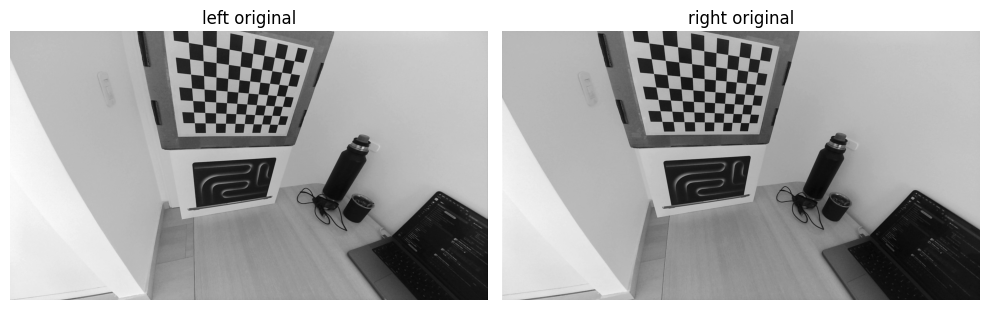

In [48]:
# tomemos un par estéreo
image_index = 3

left_image = left_images[image_index]
right_image = right_images[image_index]


show_images([
    left_image, right_image
], [
    "left original", "right original"
])

In [49]:
# aplicamos des-distorsion + rectificación, con los mapas que calculamos ateriormente
left_image_rectified = cv2.remap(left_image, left_map_x, left_map_y, cv2.INTER_LINEAR)
right_image_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)




# Ejemplo, para saber qué valor poner en la posición (i,j) de la imagen destino,
# a cuál píxel en la imagen original tendríamos que ir buscar?
x_dest, y_dest = 321, 123

x_ori = left_map_x[y_dest, x_dest]
y_ori = left_map_y[y_dest, x_dest]

x_ori = int(np.round(x_ori))
y_ori = int(np.round(y_ori))

print(f"using nearest neighbor interpolation, I_dest[{y_dest}, {x_dest}] = I_ori[{y_ori}, {x_ori}]")

print(left_image[y_ori, x_ori])
print(left_image_rectified[y_dest, x_dest])


using nearest neighbor interpolation, I_dest[123, 321] = I_ori[145, 347]
175
175


In [50]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None, ax=None, figsize=(5, 5)):
    """
    Muestra una imagen (convirtiendo de BGR a RGB si es necesario).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Asumir que es BGR si tiene 3 canales, convertir a RGB
    # (OpenCV lee en BGR, Matplotlib muestra en RGB)
    if img.ndim == 3 and img.shape[2] == 3:
        img_rgb = img[..., ::-1]  # Convertir BGR a RGB
        ax.imshow(img_rgb)
    # Si es 2D (escala de grises)
    elif img.ndim == 2:
        ax.imshow(img, cmap='gray')
    # Si ya está en RGB o es otro formato
    else:
        ax.imshow(img)
        
    ax.axis('off')
    if title:
        ax.set_title(title)
    
    return ax

def show_images(images, titles=None, figsize_per_img=(5, 5)):
    """
    Muestra una lista de imágenes una al lado de la otra.
    
    images: lista de imágenes [img1, img2, ...]
    titles: lista de títulos [title1, title2, ...]
    """
    n = len(images)
    if n == 0:
        print("No hay imágenes para mostrar.")
        # Devolvemos None para ambos para que el unpacking no falle
        return None, None

    if titles is None:
        titles = [''] * n
    
    if len(images) != len(titles):
        raise ValueError("La lista de imágenes y de títulos debe tener el mismo tamaño.")

    # Calcular el tamaño total de la figura
    figsize = (figsize_per_img[0] * n, figsize_per_img[1])
    
    fig, axes = plt.subplots(1, n, figsize=figsize)
    
    # Asegurarse de que 'axes' sea siempre una lista para poder iterar
    if n == 1:
        axes = [axes]
        
    for ax, img, title in zip(axes, images, titles):
        # Usar la función helper 'imshow'
        imshow(img, title, ax=ax)
    
    plt.tight_layout()
    
    # --- INICIO DE LA CORRECCIÓN ---
    
    # 1. ELIMINAMOS ESTA LÍNEA:
    # plt.show()
    
    # 2. AÑADIMOS ESTA LÍNEA:
    return fig, axes
    
    # --- FIN DE LA CORRECCIÓN ---

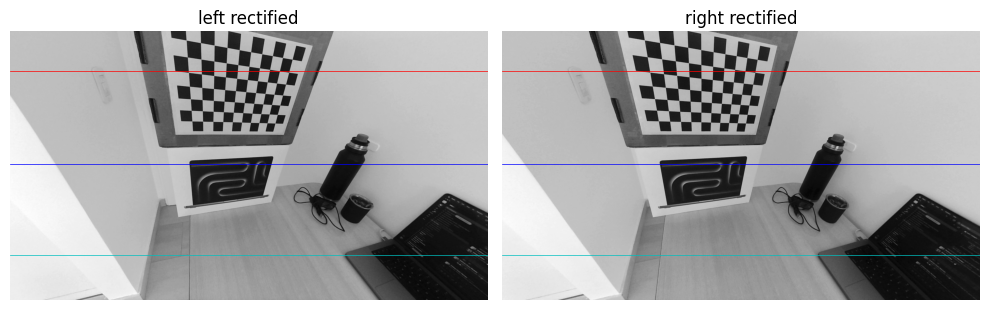

In [51]:
# muestro las imagenes stereo-rectificadas
# observar el vertice de la caja, de la notebook, y del cuaderno. 
# coinciden perfectamente en y.
from matplotlib import pyplot as plt 

fig, axes = show_images([
    left_image_rectified, right_image_rectified
], [
    "left rectified", "right rectified"
])

for y, c in zip([160, 533, 900], ['r', 'b', 'c']):
    axes[0].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
    axes[1].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
plt.show()

In [52]:
# Guardemos los resultados de rectificación para usar posteriormente:

stereo_maps = {

    # undistorting maps
    "left_map_x": left_map_x,
    "left_map_y": left_map_y,
    "right_map_x": right_map_x,
    "right_map_y": right_map_y,

    # add also rectifying info:
    "R1": R1,
    "R2": R2,
    "P1": P1_matriz,
    "P2": P2_matriz,
    "Q": Q,
    "validRoi1": validRoi1,
    "validRoi2": validRoi2,

}

stereo_maps_file = os.path.join("datasets","stereo_budha_board", "stereo_maps.pkl")
with open(stereo_maps_file, "wb") as f:
    f.write(pickle.dumps(stereo_maps))
        

## Rectificación Online

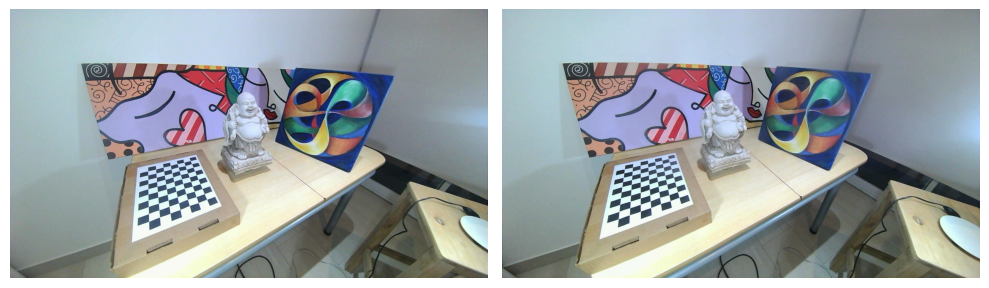

In [53]:
import os

left_image_file = os.path.join("datasets","stereo_budha_board", "captures", "left_0.jpg")
right_image_file = os.path.join("datasets","stereo_budha_board", "captures", "right_0.jpg")

# left_image = cv2.imread(left_image_file, 0)
# right_image = cv2.imread(right_image_file, 0)
left_image = cv2.imread(left_image_file, cv2.IMREAD_COLOR)
right_image = cv2.imread(right_image_file, cv2.IMREAD_COLOR)

fig, axes = show_images([left_image, right_image])

In [54]:
# cargamos la información de rectificación stereo, que generamos offline

import pickle


stereo_calib_file = os.path.join("datasets","stereo_budha_board", "stereo_calibration.pkl")
stereo_maps_file = os.path.join("datasets","stereo_budha_board", "stereo_maps.pkl")

print("reading stereo calibration results...")
with open(stereo_calib_file, "rb") as f:
    calibration = pickle.loads(f.read())
    
print("reading stereo rectification maps...")
with open(stereo_maps_file, "rb") as f:
    maps = pickle.loads(f.read())

reading stereo calibration results...
reading stereo rectification maps...


In [55]:
left_map_x, left_map_y = maps['left_map_x'], maps['left_map_y']
right_map_x, right_map_y = maps['right_map_x'], maps['right_map_y']



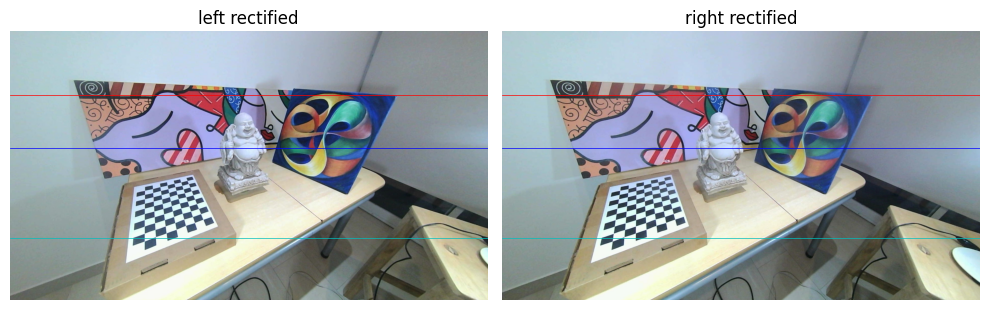

In [56]:
left_image_rectified = cv2.remap(left_image, left_map_x, left_map_y, cv2.INTER_LINEAR)
right_image_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)

cv2.imwrite("cat_left.jpg", left_image_rectified)
cv2.imwrite("cat_right.jpg", right_image_rectified)


fig, axes = show_images([
    left_image_rectified, right_image_rectified
], [
    "left rectified", "right rectified"
])

for y, c in zip([255, 470, 830], ['r', 'b', 'c']):
    axes[0].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
    axes[1].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
plt.show()

## Disparidad y Block Matching

In [57]:
# import cv2
# import numpy as np
# from cv2 import ximgproc  # Necesitas tener opencv-contrib-python instalado
# import matplotlib.pyplot as plt

# # --- 1. Configuración de SGBM (Semi-Global Block Matching) ---
# # Estos parámetros son un buen punto de partida, como pide el PDF.

# minDisparity = 0
# numDisparities = 256  # Debe ser divisible por 16
# blockSize = 5         # Un valor impar, 5 o 7 funciona bien
# sgbm_P1 = 8 * 3 * blockSize**2
# sgbm_P2 = 32 * 3 * blockSize**2
# disp12MaxDiff = 1
# uniquenessRatio = 10
# speckleWindowSize = 100
# speckleRange = 32
# mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY # Modo más completo

# # --- 2. Crear los Matchers (izquierdo y derecho) ---

# # Matcher Izquierdo
# stereo_sgbm = cv2.StereoSGBM_create(
#     minDisparity=minDisparity,
#     numDisparities=numDisparities,
#     blockSize=blockSize,
#     P1=sgbm_P1,
#     P2=sgbm_P2,
#     disp12MaxDiff=disp12MaxDiff,
#     uniquenessRatio=uniquenessRatio,
#     speckleWindowSize=speckleWindowSize,
#     speckleRange=speckleRange,
#     mode=mode
# )

# # Matcher Derecho (OBLIGATORIO para el filtro WLS)
# right_matcher = ximgproc.createRightMatcher(stereo_sgbm)

# # --- 3. Crear el Filtro WLS (la parte clave) ---
# wls_filter = ximgproc.createDisparityWLSFilter(matcher_left=stereo_sgbm)
# wls_filter.setLambda(8000.0)   # Parámetros de "suavizado"
# wls_filter.setSigmaColor(1.5) # Parámetros de "respeto por el color"

# # --- 4. Calcular y Filtrar la Disparidad ---

# # Asumo que 'left_image_rectified' y 'right_image_rectified'
# # ya están cargadas y son imágenes BGR (a color), no en gris.
# # El filtro WLS usa la imagen a color como guía.



# # --- 4. Calcular y Filtrar la Disparidad ---

# # Convertimos a gris SOLO para SGBM.compute
# left_gray_rect = cv2.cvtColor(left_image_rectified, cv2.COLOR_BGR2GRAY)
# right_gray_rect = cv2.cvtColor(right_image_rectified, cv2.COLOR_BGR2GRAY)

# print("Calculando disparidad (izquierda)...")
# disp_left = stereo_sgbm.compute(left_gray_rect, right_gray_rect)

# print("Calculando disparidad (derecha)...")
# disp_right = right_matcher.compute(right_gray_rect, left_gray_rect)

# print("Aplicando filtro WLS...")
# # ¡¡AQUÍ USAMOS LA IMAGEN BGR!!
# # Esta es la corrección clave
# disparity_filtered = wls_filter.filter(disp_left, left_image_rectified, 
#                                        disparity_map_right=disp_right)
# # ... (el resto de la celda sigue igual)


# # print("Calculando disparidad (izquierda)...")
# # disp_left = stereo_sgbm.compute(left_image_rectified, right_image_rectified)

# # print("Calculando disparidad (derecha)...")
# # disp_right = right_matcher.compute(right_image_rectified, left_image_rectified)

# # print("Aplicando filtro WLS...")
# # disparity_filtered = wls_filter.filter(disp_left, left_image_rectified, 
# #                                        disparity_map_right=disp_right)

# # --- 5. Limpieza y Normalización ---

# # El resultado del filtro se escala igual que el original
# disparity_map = disparity_filtered.astype(np.float32) / 16.0

# # Ponemos en 0 los valores inválidos (negativos) que genera el filtro
# disparity_map[disparity_map < 0] = 0

# # --- 6. Mostrar el resultado (¡Ahora sí!) ---

# print("¡Disparidad filtrada lista!")
# plt.figure(figsize=(10, 8))
# plt.imshow(disparity_map, cmap='jet')
# plt.title('Mapa de Disparidad (SGBM + Filtro WLS)')
# plt.colorbar()
# plt.show()

# # IMPORTANTE:
# # A partir de aquí, usa esta variable 'disparity_map' 
# # para tu celda que calcula la profundidad (la de 'reprojectImageTo3D')

## Profundidad

In [58]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # --- 1. Reproyectar a 3D ---
# # Usa el 'disparity_map' limpio que creaste en el paso anterior
# # y la matriz 'Q' que calculaste en la celda [11]
# print("Reproyectando a 3D...")
# points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

# # --- 2. Extraer el Mapa de Profundidad ---
# # La profundidad es el canal Z (índice 2)
# depth = points_3D[:, :, 2]

# # --- 3. Limpieza de 'inf' y 'nan' (¡LA PARTE CLAVE!) ---
# # Creamos una máscara de todos los píxeles válidos:
# #   - Donde la disparidad NO es 0 (evita división por cero)
# #   - Donde el resultado de depth NO es infinito
# #   - Donde el resultado de depth NO es "nan" (Not a Number)
# valid_mask = (disparity_map > 0) & \
#              (~np.isinf(depth)) & \
#              (~np.isnan(depth))

# # Creamos un nuevo mapa de profundidad limpio
# # Lleno de ceros al principio
# depth_cleaned = np.zeros_like(depth)

# # Copiamos SÓLO los valores válidos al mapa limpio
# depth_cleaned[valid_mask] = depth[valid_mask]


# # --- 4. Plotear con Escala de Color Inteligente ---
# # Si ploteamos de 0 al máximo, el fondo arruina la escala.
# # Debemos plotear desde la distancia MÍNIMA a la MÁXIMA del objeto.

# # Encontrar el valor más CERCANO (mínimo) del objeto
# vmin_plot = np.min(depth_cleaned[valid_mask])

# # Encontrar el valor más LEJANO (máximo) del objeto
# # Usamos un percentil (ej: 95%) para ignorar "outliers" o puntos ruidosos lejanos
# vmax_plot = np.percentile(depth_cleaned[valid_mask], 95)

# print(f"Graficando profundidad. Rango: {vmin_plot:.2f} a {vmax_plot:.2f} mm")

# plt.figure(figsize=(10, 8))
# plt.imshow(depth_cleaned, cmap='jet', vmin=vmin_plot, vmax=vmax_plot)
# plt.title('Mapa de Profundidad (Limpio y Escalado)')
# plt.colorbar()
# plt.show()

# # IMPORTANTE:
# # La variable 'points_3D' es tu nube de puntos.
# # La variable 'depth_cleaned' es tu mapa de profundidad 2D para el informe.

In [59]:
import utils
from methods import Config, StereoMethod, InputPair, StereoOutput, EnumParameter

In [60]:
# === DEPENDENCIAS ===
# pip install onnxruntime onnxruntime-gpu  # usa *-gpu* si tenés CUDA; si no, solo onnxruntime
import os
from pathlib import Path
import numpy as np
import cv2
import open3d as o3d

# (si elegiste la Opción B de alias de imports, poné acá el aliasing)

# === NUESTROS MÓDULOS ===
from methods import Config, InputPair  # Calibration es opcional si usás Q
from method_cre_stereo import CREStereo

# === RUTA DE MODELOS (se descargan automático la 1ª vez) ===
MODELS_DIR = Path("models_cre")
MODELS_DIR.mkdir(exist_ok=True)

# === INSTANCIAR EL MÉTODO CREStereo ===
cfg = Config(models_path=MODELS_DIR)  # dónde guardar los .onnx  :contentReference[oaicite:1]{index=1}
cre = CREStereo(cfg)                  # clase ya lista para inferencia ONNX       :contentReference[oaicite:2]{index=2}

# Parámetros típicos (podés cambiarlos en caliente)
cre.parameters["Mode"].set_value("combined")     # "init" o "combined"            :contentReference[oaicite:3]{index=3}
cre.parameters["Iterations"].set_value("10")     # "2","5","10","20"              :contentReference[oaicite:4]{index=4}
cre.parameters["Shape"].set_value("640x480")     # "320x240","640x480","1280x720" :contentReference[oaicite:5]{index=5}

# === SUPONEMOS QUE YA TENÉS: left_image_rectified, right_image_rectified y la matriz Q de la rectificación ===
# left_image_rectified/right_image_rectified: BGR, del mismo tamaño; Q: 4x4 de cv.stereoRectify()

def disparity_cre(left_image_rectified, right_image_rectified):
    """Devuelve disparity en píxeles del tamaño original (float32)"""
    inp = InputPair(left_image=left_image_rectified,
                    right_image=right_image_rectified,
                    calibration=None)  # no es necesaria si luego usás Q  :contentReference[oaicite:6]{index=6}
    out = cre.compute_disparity(inp)  # hace resize interno y re-escala la disparidad al tamaño original
    disp = out.disparity_pixels.astype(np.float32)  # ya viene escalada correctamente  :contentReference[oaicite:7]{index=7}
    return disp

def depth_and_cloud_from_disparity(disp, left_image_rectified, Q, valid_percentile=95):
    """Convierte disparidad -> puntos 3D con Q y arma nube O3D con colores"""
    # valores inválidos a 0
    disp = disp.copy()
    disp[disp < 0] = 0

    # reproyección 3D con Q (OpenCV)
    pts3d = cv2.reprojectImageTo3D(disp, Q)  # XYZ en el marco de la cámara izquierda
    depth = pts3d[:, :, 2]

    # máscara de válidos
    mask = (disp > 0) & (~np.isinf(depth)) & (~np.isnan(depth))
    if np.count_nonzero(mask) == 0:
        raise RuntimeError("No hay puntos válidos en la disparidad.")

    # recorte robusto para visualización (opcional)
    zmin = float(np.min(depth[mask]))
    zmax = float(np.percentile(depth[mask], valid_percentile))

    # nube de puntos coloreada
    colors = cv2.cvtColor(left_image_rectified, cv2.COLOR_BGR2RGB)
    pts = pts3d[mask]
    cols = (colors[mask] / 255.0).astype(np.float32)

    pcd = o3d.geometry.PointCloud(
        o3d.utility.Vector3dVector(pts)
    )
    pcd.colors = o3d.utility.Vector3dVector(cols)

    return depth, (zmin, zmax), pcd

# === EJEMPLO DE USO POR PAR ===
disp = disparity_cre(left_image_rectified, right_image_rectified)
depth, (zmin, zmax), pcd = depth_and_cloud_from_disparity(disp, left_image_rectified, Q)



# ACA ARRANCA LO QUE ARMO Y DESARMO











# Visualización rápida
o3d.visualization.draw_geometries([pcd])

# Guardado binario .PLY (liviano para el informe)
o3d.io.write_point_cloud("reconstruccion_cre.ply", pcd, write_ascii=False)


models_cre\crestereo_combined_iter10_480x640.onnx


True

In [61]:
# ============================
# (3) Pose de la cámara vs. "mundo" (tablero como Z=0)
# ============================
import numpy as np
import cv2 as cv
import open3d as o3d

# --- parámetros del checkerboard (los mismos que usaste en calibración) ---
CHECKERBOARD = (10, 7)      # columnas x filas de ESQUINAS INTERNAS
SQUARE_SIZE_MM = 24.2       # tamaño de cada casilla en mm

# Puntos 3D del patrón en el marco "mundo" (tablero en Z=0, origen en esquina (0,0))
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= SQUARE_SIZE_MM

# Detección de esquinas en la imagen IZQUIERDA rectificada
gray = cv.cvtColor(left_image_rectified, cv.COLOR_BGR2GRAY)
ok, corners = cv.findChessboardCorners(
    gray, CHECKERBOARD,
    flags=cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_NORMALIZE_IMAGE
)
if not ok:
    raise RuntimeError("No se detectó el checkerboard en la imagen izquierda rectificada.")

# Refinamiento sub-pixel
term = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), term)

# --- Elegir intrínsecos/distorsión para solvePnP ---
K_use, D_use = None, None
try:
    _ = left_K, left_dist
    K_use = left_K.astype(np.float32).copy()
    D_use = left_dist.astype(np.float32).copy()
except NameError:
    # Fallback: usar P1_matriz (proyección de la izquierda) de stereoRectify; distorsión ~0
    fx = P1_matriz[0, 0]; fy = P1_matriz[1, 1]
    cx = P1_matriz[0, 2]; cy = P1_matriz[1, 2]
    K_use = np.array([[fx, 0, cx],
                      [0, fy, cy],
                      [0,  0,  1]], dtype=np.float32)
    D_use = np.zeros((5, 1), dtype=np.float32)

# --- solvePnP: del mundo (tablero) a la cámara (izquierda) ---
ok, rvec, tvec = cv.solvePnP(objp, corners, K_use, D_use, flags=cv.SOLVEPNP_ITERATIVE)
if not ok:
    raise RuntimeError("No se pudo estimar la pose con solvePnP.")

Rcw, _ = cv.Rodrigues(rvec)        # rotación mundo->cámara
tcw = tvec.reshape(3, 1)           # traslación mundo->cámara

# (4) Convertir a cámara->mundo (para transformar la nube y visualizar marcos)
Rwc = Rcw.T
twc = (-Rcw.T @ tcw).reshape(3)

# ============================
# (3a) Ejes canónicos del mundo y (3b) frustum/pose de la cámara
# ============================
world_axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50.0)  # 50 mm
cam_axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50.0)
cam_axes.rotate(Rwc, center=(0, 0, 0))
cam_axes.translate(twc)

# Frustum de la cámara izquierda
H, W = left_image_rectified.shape[:2]
# Open3D usa una "pinhole" con K normalizada; convertimos a 4x4 extrínseca
T_wc = np.eye(4, dtype=np.float64)
T_wc[:3, :3] = Rwc
T_wc[:3, 3]  = twc
cam_frustum = o3d.geometry.LineSet.create_camera_visualization(
    view_width_px=W, view_height_px=H, intrinsic=K_use, extrinsic=T_wc, scale=50.0
)

# ============================
# (4) Transformar nube del marco de cámara -> marco del mundo
# ============================
pcd_world = o3d.geometry.PointCloud(pcd)  # copia
pcd_world.rotate(Rwc, center=(0, 0, 0))
pcd_world.translate(twc)

# ============================
# ROI 2D anclada al tablero -> OBB automático en el mundo
# ============================
import numpy as np
import cv2 as cv
import open3d as o3d

# 1) ROI 2D en la izquierda rectificada (del lado del buda)
H, W = disp.shape
xs = corners[:,0,0]; ys = corners[:,0,1]
x_min_cb, x_max_cb = float(xs.min()), float(xs.max())
y_min_cb, y_max_cb = float(ys.min()), float(ys.max())
w_cb_px = x_max_cb - x_min_cb
h_cb_px = y_max_cb - y_min_cb

def clamp(v, lo, hi): return int(max(lo, min(hi, v)))

# buda: a la derecha del tablero y un poco por arriba
RIGHT_OFF_MIN = 0.10
RIGHT_OFF_MAX = 2.00
Y_TOP_PAD     = 1.10
Y_BOTTOM_PAD  = 0.30

x1 = clamp(x_max_cb + RIGHT_OFF_MIN*w_cb_px, 0, W-1)
x2 = clamp(x_max_cb + RIGHT_OFF_MAX*w_cb_px, 0, W-1)
y1 = clamp(y_min_cb - Y_TOP_PAD*h_cb_px,     0, H-1)
y2 = clamp(y_max_cb + Y_BOTTOM_PAD*h_cb_px,  0, H-1)

# 2) Reproyección SOLO de la ROI -> 3D (marco cámara)
disp_roi = disp.copy().astype(np.float32)
disp_roi[disp_roi < 0] = 0
pts3d_cam = cv.reprojectImageTo3D(disp_roi, Q)
depth = pts3d_cam[:,:,2]

roi_mask = np.zeros_like(disp_roi, dtype=bool)
roi_mask[y1:y2+1, x1:x2+1] = True
valid = (disp_roi > 0) & np.isfinite(depth) & roi_mask

pts_cam = pts3d_cam[valid]
cols    = cv.cvtColor(left_image_rectified, cv.COLOR_BGR2RGB)[valid] / 255.0

pcd_roi_cam = o3d.geometry.PointCloud()
pcd_roi_cam.points = o3d.utility.Vector3dVector(pts_cam)
pcd_roi_cam.colors = o3d.utility.Vector3dVector(cols.astype(np.float32))

if len(pcd_roi_cam.points) < 200:
    print("ROI demasiado chica: ajustá RIGHT_OFF_MAX / Y_TOP_PAD.")
    o3d.visualization.draw_geometries([pcd_world])
else:
    # 3) Transformar esa ROI al marco del MUNDO
    pcd_roi_world = o3d.geometry.PointCloud(pcd_roi_cam)
    pcd_roi_world.rotate(Rwc, center=(0,0,0))
    pcd_roi_world.translate(twc)

    # Limpieza suave para sacar puntitos sueltos
    pcd_roi_world = pcd_roi_world.voxel_down_sample(1.5)
    pcd_roi_world, _ = pcd_roi_world.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.5)

    # 4) OBB automático (PCA) + un pequeño padding
    obb = pcd_roi_world.get_oriented_bounding_box()
    pad = np.array([15.0, 15.0, 25.0])  # mm
    obb.extent = obb.extent + pad

    # 5) Recortar la nube COMPLETA (en el mundo) con el OBB
    idx = obb.get_point_indices_within_bounding_box(pcd_world.points)
    pcd_buddha_world = pcd_world.select_by_index(idx)

    # debugging: dibujar escena + OBB + frustum
    obb.color = (0,0,1)
    o3d.visualization.draw_geometries([pcd_world, obb, world_axes, cam_axes, cam_frustum])

    if len(pcd_buddha_world.points) == 0:
        print("El OBB no atrapó puntos; ampliá RIGHT_OFF_MAX o Y_TOP_PAD, o subí el pad.")
        o3d.visualization.draw_geometries([pcd_world])
    else:
        # limpieza final y visualización del buda solo
        pcd_buddha_world = pcd_buddha_world.voxel_down_sample(1.5)
        pcd_buddha_world, _ = pcd_buddha_world.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.5)
        o3d.visualization.draw_geometries([pcd_buddha_world, world_axes, cam_axes])
        o3d.io.write_point_cloud("buddha_world_only.ply", pcd_buddha_world, write_ascii=False)
